# Neuro-Nav Tutorial Notebook

In [1]:
from neuronav.envs.grid_env import GridEnv, GridSize, GridObsType, OrientationType
from neuronav.envs.graph_env import GraphEnv, GraphObsType
from neuronav.agents.td_agents import TDSR
from neuronav.envs.grid_topographies import GridTopography
from neuronav.envs.graph_structures import GraphStructure
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import networkx as nx

/Users/awjuliani/miniconda3/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


## Using the `GridEnv`

For information on supported environment topographies and observation spaces, see [here](https://github.com/awjuliani/neuro-nav/tree/main/neuronav/envs#gridenv).

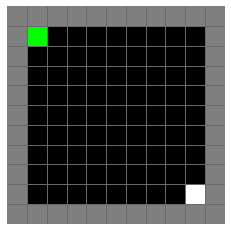

In [2]:
env = GridEnv(
    topography=GridTopography.empty, 
    grid_size=GridSize.small, 
    obs_type=GridObsType.index, 
    orientation_type=OrientationType.fixed
)
obs = env.reset()
env.render()

### Training an agent to reach the goal

Text(0, 0.5, 'Time-steps')

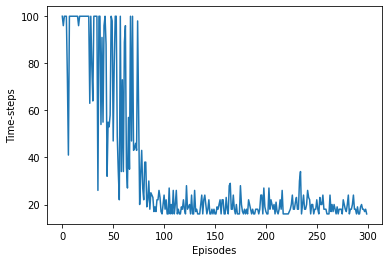

In [3]:
num_eps = 300
num_steps = 100

agent = TDSR(env.state_size, env.action_space.n, lr=1e-1, poltype="egreedy", epsilon=0.2, gamma=0.9)

tot_steps = []
for i in range(num_eps):
    obs = env.reset()
    steps = 0
    done = False
    while not done and steps < num_steps:
        act = agent.sample_action(obs)
        obs_new, reward, done, _ = env.step(act)
        agent.update([obs, act, obs_new, reward, done])
        obs = obs_new
        steps += 1
    tot_steps.append(steps)
plt.plot(tot_steps)
plt.xlabel("Episodes")
plt.ylabel("Time-steps")

### Visualizing the agent's value function

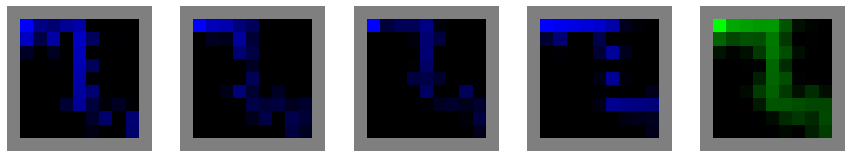

In [4]:
y = 5

fig, axs = plt.subplots(1, y, figsize=(y*3, 3))

for j in range(y):
    axs[j].axis("off")
    b = env.grid(render_objects=False)
    if j < y - 1:
        a = agent.Q[j].reshape(env.grid_size, env.grid_size)
        b[:,:,2] += np.clip(np.sqrt(a), 0, 1)
    else:
        a = np.mean(agent.Q, axis=0).reshape(env.grid_size, env.grid_size)
        b[:,:,1] += np.clip(np.sqrt(a), 0, 1)
    axs[j].imshow(b)

### Analyzing the successor representation of an agent

In [5]:
agent = TDSR(env.state_size, env.action_space.n, lr=1e-2)
num_eps = 1000
num_steps = 100

m_map = {}
for i in range(num_eps):
    start_pos = list(np.random.randint(1, env.grid_size-1, [2]))
    obs = env.reset(agent_pos=start_pos)
    steps = 0
    done = False
    while not done and steps < num_steps:
        act = env.action_space.sample()
        obs_new, reward, done, _ = env.step(act)
        agent.update([obs, act, obs_new, reward, done])
        m_map[obs] = np.mean(agent.M[:, obs], axis=0)
        obs = obs_new
        steps += 1

m_map = np.stack(list(m_map.values()))

#### Visualization of successor "place cells"

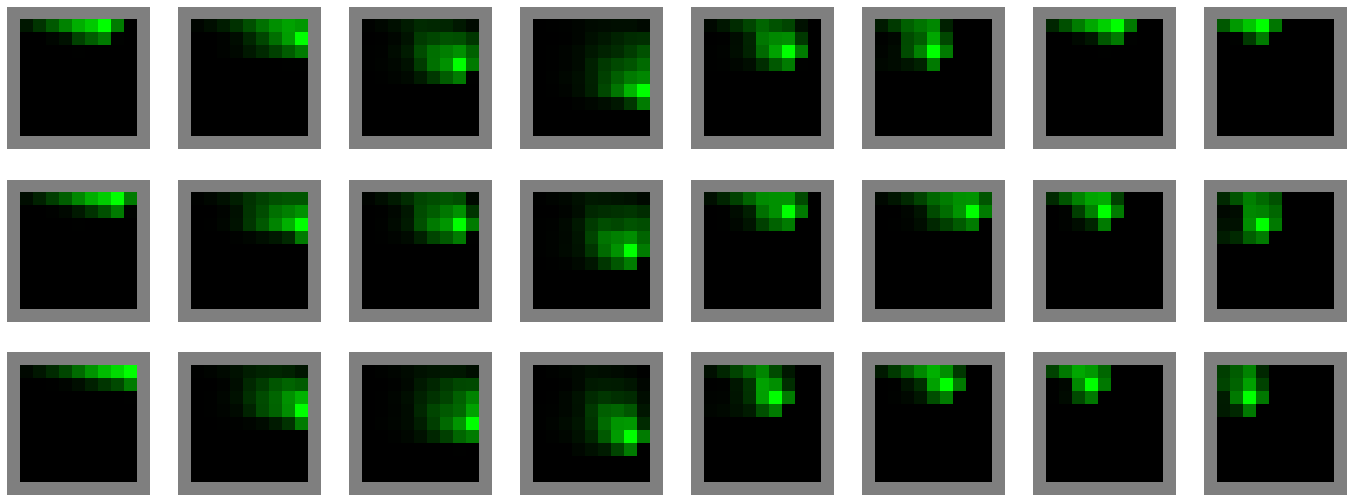

In [6]:
x, y= 8, 3

fig, axs = plt.subplots(y, x, figsize=(x*3, y*3))

for i in range(x):
    for j in range(y):
        axs[j,i].axis("off")
        a = m_map[i * y + j].reshape(env.grid_size, env.grid_size)
        b = env.grid(render_objects=False)
        b[:,:,1] += np.clip(np.sqrt(a), 0, 1)
        axs[j,i].imshow(b)

#### Visualization of successor "grid cells"

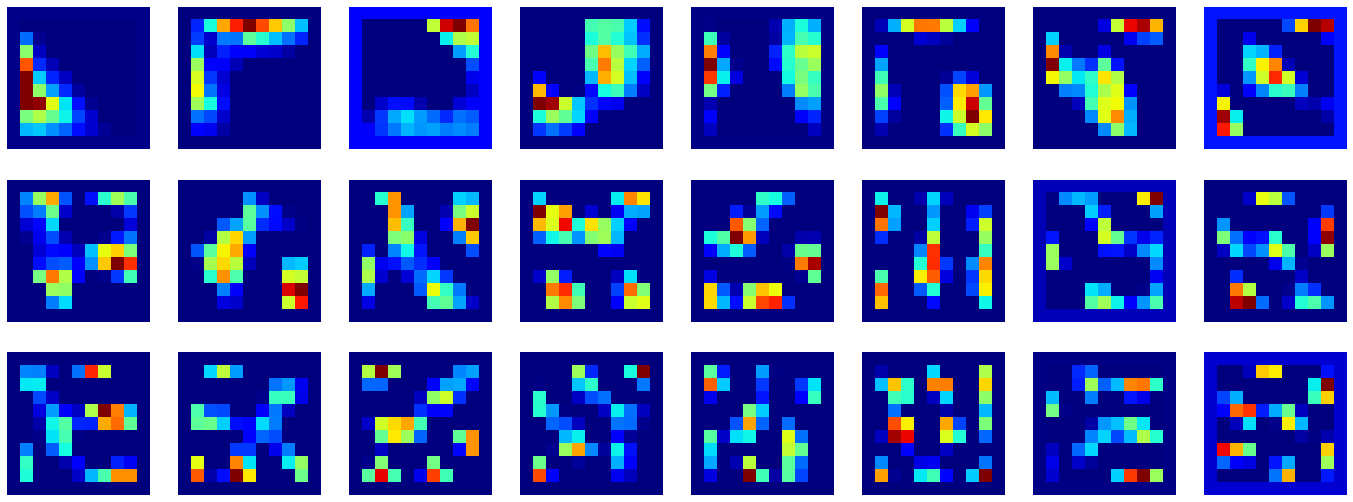

In [7]:
y = 8
x = 3

mean_m = np.mean(agent.M, axis=0)
pca = PCA(n_components=y*x, svd_solver='full')
result = pca.fit_transform(mean_m.T)
result = np.clip(result, 0, 1)


fig, axs = plt.subplots(x, y, figsize=(y*3, x*3))

for j in range(x):
    for i in range(y):
        axs[j,i].axis("off")
        axs[j,i].imshow(result[:,(i+(j*y))].reshape(env.grid_size, env.grid_size), cmap='jet')

## Using the `GraphEnv`

For information on supported environment structures and observation spaces, see [here](https://github.com/awjuliani/neuro-nav/tree/main/neuronav/envs#graphenv).

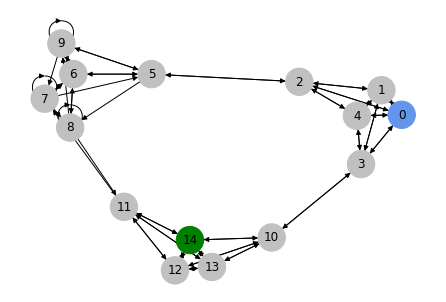

In [8]:
env = GraphEnv(
    graph_structure=GraphStructure.neighborhood, 
    obs_type=GraphObsType.index
)
env.reset()
env.render()

### Training an agent to reach the goal

Text(0, 0.5, 'Time-steps')

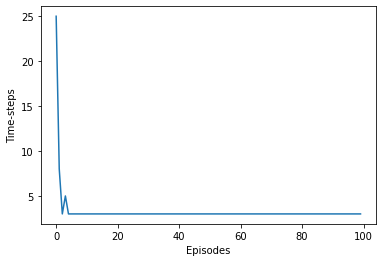

In [9]:
num_eps = 100
num_steps = 25

agent = TDSR(env.state_size, env.action_space.n, lr=1e-1)

tot_steps = []
for i in range(num_eps):
    obs = env.reset()
    done = False
    steps = 0
    while not done and steps < num_steps:
        act = agent.sample_action(obs)
        obs_new, reward, done, _ = env.step(act)
        agent.update([obs, act, obs_new, reward, done])
        obs = obs_new
        steps += 1
    tot_steps.append(steps)
plt.plot(tot_steps)
plt.xlabel("Episodes")
plt.ylabel("Time-steps")

### Visualizing the agent's value function

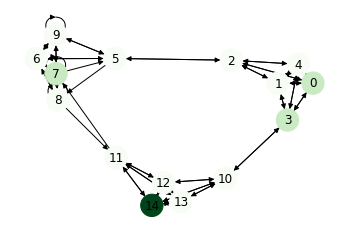

In [10]:
mean_q = np.mean(agent.Q, axis=0)

plt.axis("off")
graph = nx.DiGraph()
color_map = []
for idx, edge in enumerate(env.edges):
    color_map.append(mean_q[idx])
    for target in edge:
        graph.add_edge(idx, target)
nx.draw(graph, with_labels=True, node_color=color_map, node_size=500, cmap="Greens")


### Analyzing the successor representation of an agent

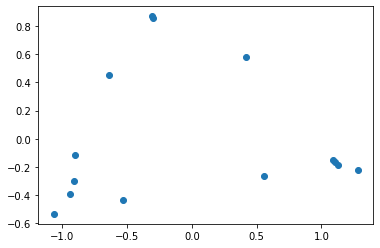

In [11]:
agent = TDSR(env.state_size, env.action_space.n, lr=1e-1)

m_map = {}
for i in range(num_eps):
    obs = env.reset()
    done = False
    steps = 0
    while not done and steps < num_steps:
        act = env.action_space.sample()
        obs_new, reward, done, _ = env.step(act)
        agent.update([obs, act, obs_new, reward, done])
        m_map[obs] = np.mean(agent.M[:, obs], axis=0)
        obs = obs_new
        steps += 1

m_map = np.stack(list(m_map.values()))
embedding = PCA(n_components=2)
low_M = embedding.fit_transform(m_map)
plt.scatter(low_M[:, 0], low_M[:, 1])

### Visualization of successor "place cells"

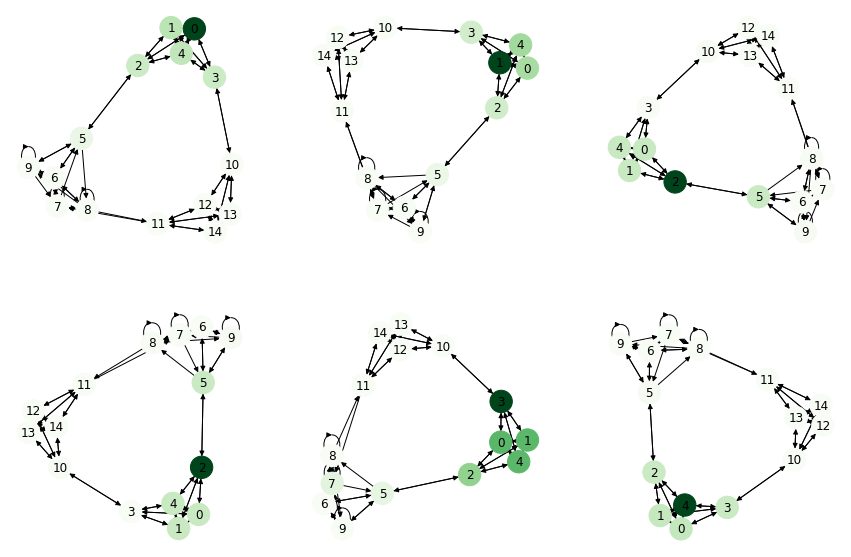

In [12]:
mean_m = np.mean(agent.M, axis=0)

x, y= 3, 2

fig, axs = plt.subplots(y, x, figsize=(x*5, y*5))

for i in range(x):
    for j in range(y):
        axs[j,i].axis("off")
        graph = nx.DiGraph()
        color_map = []
        for idx, edge in enumerate(env.edges):
            color_map.append(mean_m[idx, i + j * 2])
            for target in edge:
                graph.add_edge(idx, target)
        nx.draw(graph, with_labels=True, node_color=color_map, node_size=500, ax=axs[j,i], cmap="Greens")
